In [1]:
# imports

import pandas as pd
import geopandas as gpd



In [2]:
# load data
df = pd.read_csv('data/AeroConnectData.csv')
df = df[df['Year'] != 1989]


In [3]:
# streamline data so it has route and date column
df['Route'] = df['AustralianPort'] + ' <-> ' + df['ForeignPort'] + ' (' + df['Country'] + ')'
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month_num'].astype(str) + '-01')



In [4]:
# 1a: most trafficked routes
numRoutes = 10
top_routes_passengers = df.groupby('Route')['Passengers_Total'].sum().sort_values(ascending=False).head(numRoutes)
top_routes_freight = df.groupby('Route')['Freight_Total_(tonnes)'].sum().sort_values(ascending=False).head(numRoutes)
top_routes_mail = df.groupby('Route')['Mail_Total_(tonnes)'].sum().sort_values(ascending=False).head(numRoutes)
print("top passenger routes")
print(top_routes_passengers)
print("top freight routes")
print(top_routes_freight)
print("top mail routes")
print(top_routes_mail)

top passenger routes
Route
Sydney <-> Auckland (New Zealand)        2653962
Sydney <-> Singapore (Singapore)         1254400
Sydney <-> Tokyo (Japan)                 1083712
Sydney <-> Hong Kong (Hong Kong)          996685
Perth <-> Singapore (Singapore)           819957
Brisbane <-> Auckland (New Zealand)       794279
Sydney <-> Christchurch (New Zealand)     793254
Melbourne <-> Singapore (Singapore)       748667
Sydney <-> Honolulu (USA)                 737571
Sydney <-> Los Angeles (USA)              730211
Name: Passengers_Total, dtype: int64
top freight routes
Route
Sydney <-> Auckland (New Zealand)       112470.433
Sydney <-> Tokyo (Japan)                 66087.409
Sydney <-> Singapore (Singapore)         59473.113
Sydney <-> Los Angeles (USA)             57781.598
Perth <-> Singapore (Singapore)          47233.724
Sydney <-> Hong Kong (Hong Kong)         45697.625
Melbourne <-> Singapore (Singapore)      43104.967
Melbourne <-> Auckland (New Zealand)     36346.202
Melbourne <->

In [5]:
# 1a: least trafficked routes
numRoutes = 10
top_routes_passengers = df.groupby('Route')['Passengers_Total'].sum().sort_values(ascending=True).head(numRoutes)
top_routes_freight = df.groupby('Route')['Freight_Total_(tonnes)'].sum().sort_values(ascending=True).head(numRoutes)
top_routes_mail = df.groupby('Route')['Mail_Total_(tonnes)'].sum().sort_values(ascending=True).head(numRoutes)
print("bottom passenger routes")
print(top_routes_passengers)
print("bottom freight routes")
print(top_routes_freight)
print("bottom mail routes")
print(top_routes_mail)

bottom passenger routes
Route
Melbourne <-> Denver (USA)                0
Hobart <-> Tokyo (Japan)                  0
Brisbane <-> Colombo (Sri Lanka)          0
Perth <-> Bandar Seri Begawan (Brunei)    0
Adelaide <-> Harare (Zimbabwe)            0
Townsville <-> San Francisco (USA)        1
Cairns <-> Honiara (Solomon Islands)      1
Darwin <-> Zagreb (Yugoslavia)            1
Adelaide <-> New York (USA)               1
Townsville <-> Amsterdam (Netherlands)    1
Name: Passengers_Total, dtype: int64
bottom freight routes
Route
Townsville <-> Zagreb (Yugoslavia)      0.0
Sydney <-> Ljubljana (Yugoslavia)       0.0
Cairns <-> Papeete (Tahiti)             0.0
Cairns <-> Nagoya (Japan)               0.0
Cairns <-> Manila (Philippines)         0.0
Cairns <-> Manchester (UK)              0.0
Cairns <-> Larnaca (Cyprus)             0.0
Cairns <-> Kieta (Papua New Guinea)     0.0
Cairns <-> Honiara (Solomon Islands)    0.0
Cairns <-> Frankfurt (Germany)          0.0
Name: Freight_Total_(tonn

In [6]:
# 1b: growth by year

# Annual trends
annual_traffic = df.groupby('Year')['Passengers_Total'].sum()
print("Annual Traffic Growth:")
annual_growth = annual_traffic.pct_change() * 100
for year in annual_traffic.index:
    if year > 1985:
        growth_pct = annual_growth[year]
        growth_absolute = annual_traffic[year] - annual_traffic[year-1]
        if growth_absolute > 0:
            print(f"{year}: {annual_traffic[year]:,} passengers (+{growth_absolute:,} passengers, +{growth_pct:.1f}%)")
        else:
            print(f"{year}: {annual_traffic[year]:,} passengers (-{-1*growth_absolute:,} passengers, -{-1*growth_pct:.1f}%)")
    else:
        print(f"{year}: {annual_traffic[year]:,} passengers (first year)")



Annual Traffic Growth:
1985: 5,200,373 passengers (first year)
1986: 5,818,437 passengers (+618,064 passengers, +11.9%)
1987: 6,714,432 passengers (+895,995 passengers, +15.4%)
1988: 7,766,782 passengers (+1,052,350 passengers, +15.7%)


In [7]:
# 1b: most popular destination locations
# 1b: proportion of passengers categorized by original location

country_traffic = df.groupby('Country')['Passengers_Total'].sum().sort_values(ascending=False)
aus_port_traffic = df.groupby('AustralianPort')['Passengers_Total'].sum().sort_values(ascending=False)

print("\nGeographic Hotspots:")
print("Top 5 Countries:")
for i, (country, traffic) in enumerate(country_traffic.head(5).items(), 1):
    print(f"{i}. {country}: {traffic:,} passengers")

print("\nAustralian Port Distribution:")
for port, traffic in aus_port_traffic.items():
    pct = (traffic / aus_port_traffic.sum()) * 100
    print(f"{port}: {pct:.1f}% of traffic")


Geographic Hotspots:
Top 5 Countries:
1. New Zealand: 7,002,785 passengers
2. Singapore: 3,554,958 passengers
3. USA: 2,656,098 passengers
4. Hong Kong: 1,933,900 passengers
5. UK: 1,528,954 passengers

Australian Port Distribution:
Sydney: 53.1% of traffic
Melbourne: 21.2% of traffic
Brisbane: 10.7% of traffic
Perth: 9.5% of traffic
Adelaide: 2.1% of traffic
Cairns: 1.5% of traffic
Darwin: 0.9% of traffic
Townsville: 0.4% of traffic
Norfolk Island: 0.3% of traffic
Hobart: 0.2% of traffic
Port Hedland: 0.1% of traffic


In [8]:
# update with port locations
from shapely.geometry import Point

# port coordinates
port_coords = {
    'Sydney': [-33.8688, 151.2093],
    'Melbourne': [-37.8136, 144.9631],
    'Brisbane': [-27.4698, 153.0251],
    'Perth': [-31.9505, 115.8605],
    'Adelaide': [-34.9285, 138.6007],
    'Cairns': [-16.9186, 145.7781],
    'Darwin': [-12.4634, 130.8456],
    'Townsville': [-19.2590, 146.8169],
    'Norfolk Island': [-29.0408, 167.9547],
    'Hobart': [-42.8821, 147.3272],
    'Port Hedland': [-20.3106, 118.5717]
}

#
port_data = []
for port, coords in port_coords.items():
    if port in aus_port_traffic.index:
        port_data.append({
            'port': port,
            'lat': coords[0],
            'lon': coords[1],
            'passengers': aus_port_traffic[port],
            'percentage': (aus_port_traffic[port] / aus_port_traffic.sum()) * 100
        })

ports_df = pd.DataFrame(port_data)
ports_gdf = gpd.GeoDataFrame(ports_df,
                            geometry=[Point(xy) for xy in zip(ports_df.lon, ports_df.lat)],
                            crs="EPSG:4326")

print(f"Created ports_gdf with {len(ports_gdf)} ports")

Created ports_gdf with 11 ports


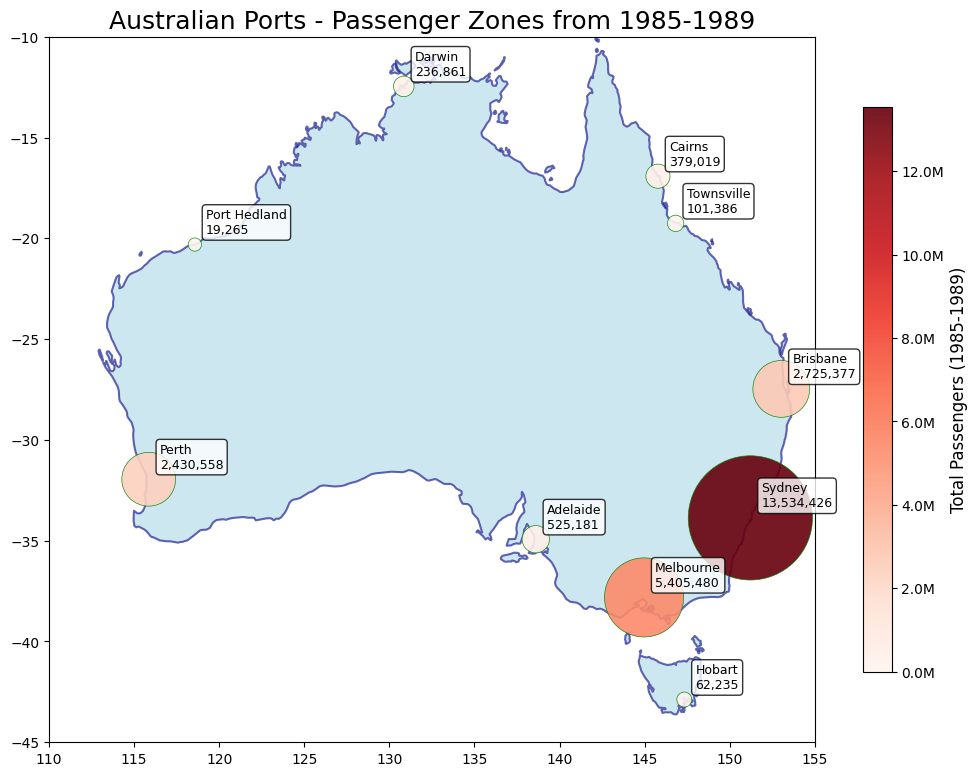

In [9]:
# 1c: australian map with starting ports
import geopandas as gpd
import matplotlib.pyplot as plt

url = 'https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_50m_admin_0_countries.geojson'

# load world map
world = gpd.read_file(url)


name_cols = ['NAME', 'NAME_EN', 'name', 'ADMIN']
australia = None
for col in name_cols:
    if col in world.columns:
        australia = world[world[col] == 'Australia']
        if len(australia) > 0:
            break

# display the map
fig, ax = plt.subplots(1, 1, figsize=(16 * 0.65, 12 * 0.65))

if australia is not None and len(australia) > 0:
    # plot Australia
    australia.plot(ax=ax, color='lightblue', edgecolor='navy', linewidth=1.5, alpha=0.6)

    # calculate sizes with proportional scaling
    min_size = 80
    max_size = 8000
    percentages = ports_gdf['percentage']
    sizes = min_size + (percentages / percentages.max()) * (max_size - min_size)

    scatter = ax.scatter(ports_gdf['lon'], ports_gdf['lat'],
                    s=sizes,
                    c=ports_gdf['passengers'],
                    cmap='Reds',
                    vmin=0,
                    vmax=ports_gdf['passengers'].max(),
                    alpha=0.9,
                    edgecolors='green',
                    linewidth=0.5,
                    zorder=1)


    cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
    cbar.set_label('Total Passengers (1985-1989)', fontsize=12)

    import matplotlib.ticker as ticker
    def millions_formatter(x, pos):
        return f'{x/1e6:.1f}M'
    cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))

    for idx, row in ports_gdf.iterrows():
        ax.annotate(f"{row['port']}\n{row['passengers']:,}",
                    xy=(row['lon'], row['lat']),
                    xytext=(8, 8), textcoords='offset points',
                    fontsize=9, ha='left',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

    ax.set_xlim(110, 155)
    ax.set_ylim(-45, -10)
    ax.set_title('Australian Ports - Passenger Zones from 1985-1989', fontsize=18,)

else:
    print("❌ Could not find Australia in dataset")

plt.tight_layout()
plt.show()


In [10]:
from geopy.distance import geodesic as GD
from geopy.geocoders import Nominatim

/Users/arjunsikka/PycharmProjects/data-tech-challenge/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [11]:
city1 = "Adelaide"
city2 = "Auckland"
geolocator = Nominatim(user_agent="MyApp")
location_city1 = geolocator.geocode(city1)
location_city2 = geolocator.geocode(city2)
lat_long_city1 = (location_city1.latitude ,location_city1.longitude)
lat_long_city2 = (location_city2.latitude ,location_city2.longitude)
distance = GD(lat_long_city1 , lat_long_city2).km
print(f"The distance between {city1} and {city2} is { distance}")






The distance between Adelaide and Auckland is 3252.650600130042


In [12]:
from geopy import distance
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="MyApp")

# get unique routes with their total passengers
route_totals = df.groupby(['AustralianPort', 'ForeignPort'])['Passengers_Total'].sum().reset_index()

# calculate distances for each route
route_distances = []
print("Calculating distances for routes...")

for _, row in route_totals.iterrows():
    city1 = row['AustralianPort']
    if city1 != "Sydney":
        continue
    city2 = row['ForeignPort']
    total_passengers = row['Passengers_Total']

    try:
        # get coordinates for both cities
        location_city1 = geolocator.geocode(city1)
        location_city2 = geolocator.geocode(city2)

        if location_city1 and location_city2:
            lat_long_city1 = (location_city1.latitude, location_city1.longitude)
            lat_long_city2 = (location_city2.latitude, location_city2.longitude)

            # calculate distance
            route_distance = distance.distance(lat_long_city1, lat_long_city2).km

            route_distances.append({
                'Route': f"{city1} <-> {city2}",
                'Distance_km': round(route_distance, 0),
                'Total_Passengers': total_passengers
            })

            print(f"{city1} <-> {city2}: {route_distance:.0f} km, {total_passengers:,} passengers")

    except Exception as e:
        print(f"Could not calculate distance for {city1} <-> {city2}: {e}")

# create DataFrame
distance_df = pd.DataFrame(route_distances)
print(f"\nSuccessfully calculated distances for {len(distance_df)} routes")

Calculating distances for routes...
Sydney <-> Abu Dhabi: 12082 km, 19,992 passengers
Sydney <-> Amsterdam: 16638 km, 61,519 passengers
Sydney <-> Apia: 4340 km, 22,893 passengers
Could not calculate distance for Sydney <-> Athens: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Athens&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
Sydney <-> Auckland: 2161 km, 2,653,962 passengers
Sydney <-> Bahrain: 12512 km, 16,265 passengers
Sydney <-> Bandar Seri Begawan: 5740 km, 255 passengers
Sydney <-> Bangkok: 7524 km, 352,597 passengers
Sydney <-> Beijing: 8946 km, 68,120 passengers
Sydney <-> Belgrade: 15676 km, 112,838 passengers
Sydney <-> Bombay: 10149 km, 105,564 passengers
Sydney <-> Buenos Aires: 11821 km, 2,368 passengers
Sydney <-> Christchurch: 2141 km, 793,254 passengers
Could not calculate distance for Sydney <-> Colo

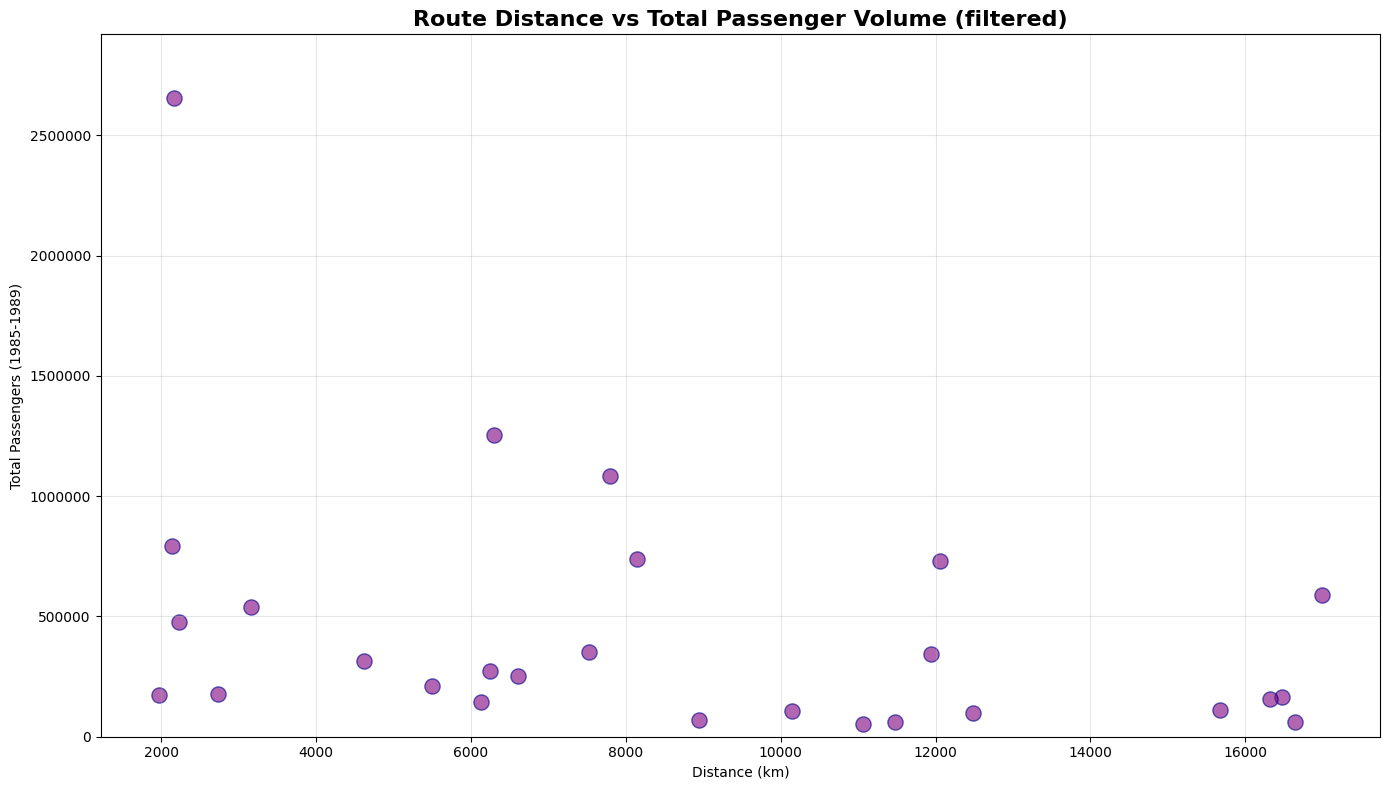


Routes after filtering: 27
Routes filtered out: 26


In [13]:
plt.figure(figsize=(14, 8))

if len(distance_df) > 0:
    # filter out routes
    distance_df_filtered = distance_df[distance_df['Total_Passengers'] >= 50000]

    # create scatter plot with filtered data
    plt.scatter(distance_df_filtered['Distance_km'], distance_df_filtered['Total_Passengers'],
               s=120, alpha=0.6, c='purple', edgecolors='darkblue')

    plt.xlabel('Distance (km)')
    plt.ylabel('Total Passengers (1985-1989)')
    plt.title('Route Distance vs Total Passenger Volume (filtered)', fontsize=16, fontweight='bold')
    plt.grid(True, alpha=0.3)

    plt.ylim(0, distance_df_filtered['Total_Passengers'].max() * 1.1)
    plt.ticklabel_format(style='plain', axis='y')  # Turn off scientific notation

    plt.tight_layout()
    plt.show()

    print(f"\nRoutes after filtering: {len(distance_df_filtered)}")
    print(f"Routes filtered out: {len(distance_df) - len(distance_df_filtered)}")